# Multi-view Diffusion

Multi-view diffusion is a type of diffusion model that turns an image of an object into multiple views of that object.

## Setup

Install the required libraries.

Here, we use a custom [requirements file](https://huggingface.co/spaces/dylanebert/multi-view-diffusion/blob/main/requirements.txt) to install a large number of dependencies. This is because the [Diffusers](https://huggingface.co/docs/diffusers/en/index) library doesn't officially support multi-view diffusion.

In [1]:
!pip install -r https://huggingface.co/spaces/dylanebert/multi-view-diffusion/raw/main/requirements.txt
!pip uninstall -y huggingface_hub
!pip install huggingface_hub==0.25.0
!pip uninstall -y peft
!pip install peft==0.10.0


  Using cached huggingface_hub-0.22.2-py3-none-any.whl.metadata (12 kB)
Using cached huggingface_hub-0.22.2-py3-none-any.whl (388 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.25.0
    Uninstalling huggingface-hub-0.25.0:
      Successfully uninstalled huggingface-hub-0.25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires huggingface-hub>=0.24.0, but you have huggingface-hub 0.22.2 which is incompatible.
datasets 4.0.0 requires requests>=2.32.2, but you have requests 2.31.0 which is incompatible.
datasets 4.0.0 requires tqdm>=4.66.3, but you have tqdm 4.66.2 which is incompatible.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.39.2 which is incompatible.
peft 0.16.0 requires huggingface_hub>=0.25.0, but you have huggingface-hub 0.22.2 which is

## Pipeline

Create a multi-view diffusion pipeline. Diffusers doesn't officially support multi-view-diffusion, so we load a [custom pipeline](https://huggingface.co/docs/diffusers/v0.6.0/en/using-diffusers/custom_pipelines).

In [2]:
import torch
from diffusers import DiffusionPipeline

multi_view_diffusion_pipeline = DiffusionPipeline.from_pretrained(
    "dylanebert/multi-view-diffusion",
    custom_pipeline="dylanebert/multi-view-diffusion",
    torch_dtype=torch.float16,
    trust_remote_code=True,
).to("cuda")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_token.py:90: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when poss

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Load the input image.

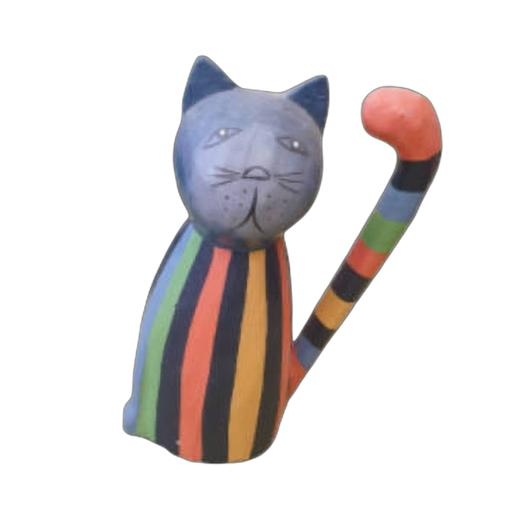

In [3]:
import requests
from PIL import Image
from io import BytesIO


image_url = "https://huggingface.co/datasets/dylanebert/3d-arena/resolve/main/inputs/images/a_cat_statue.jpg"
response = requests.get(image_url)
image = Image.open(BytesIO(response.content))
image

Pass the image through the multi-view diffusion pipeline.

  0%|          | 0/30 [00:00<?, ?it/s]

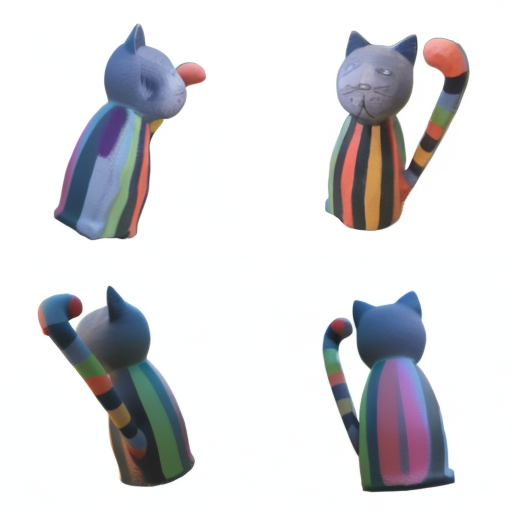

In [4]:
import numpy as np

def create_image_grid(images):
    images = [Image.fromarray((img * 255).astype("uint8")) for img in images]

    width, height = images[0].size
    grid_img = Image.new("RGB", (2 * width, 2 * height))

    grid_img.paste(images[0], (0, 0))
    grid_img.paste(images[1], (width, 0))
    grid_img.paste(images[2], (0, height))
    grid_img.paste(images[3], (width, height))

    return grid_img

image = np.array(image, dtype=np.float32) / 255.0
images = multi_view_diffusion_pipeline("", image, guidance_scale=5, num_inference_steps=30, elevation=0)

create_image_grid(images)

## Gradio Demo

In [5]:
import gradio as gr

def run(image):
  image = np.array(image, dtype=np.float32) / 255.0
  images = multi_view_diffusion_pipeline("", image, guidance_scale=5, num_inference_steps=30, elevation=0)

  images = [Image.fromarray((img * 255).astype("uint8")) for img in images]

  width, height = images[0].size
  grid_img = Image.new("RGB", (2 * width, 2 * height))

  grid_img.paste(images[0], (0, 0))
  grid_img.paste(images[1], (width, 0))
  grid_img.paste(images[2], (0, height))
  grid_img.paste(images[3], (width, height))

  return grid_img

demo = gr.Interface(fn=run, inputs="image", outputs="image")
demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
IMPORTANT: You are using gradio version 4.24.0, however version 4.44.1 is available, please upgrade.
--------
Running on public URL: https://64007ab565773ec553.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
